In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


이전에 다룬 로지스틱 회귀와 마찬가지로 이번 챕터에서 다루는 SVM은 거의 이진 분류에 관한 것이다.<br>
로지스틱 회귀가 두 클래스 간 거리를 최대화하는 분리선을 찾아내는 것이었다면 SVM 역시 마찬가지로 두 클래스 사이의 margin을 최대화하면서 에러를 최소화하려고 시도한다.

만일 training example의 수에 비해 많은 feature를 가진 문제라면 로지스틱 회귀 혹은 선형 SVM을 시도하기를 권한다. <br>
만일 training example의 수가 많거나 데이터가 선형적으로 나눠지지 않는다면 가우시안 커널을 사용하는 SVM 알고리즘을 사용하길 권한다.

# Introduction
SVM의 기본적인 아이디어는 두 클래스 사이의 선형경계(hyperplane)를 찾는 것이다.<br>
우선 두 개의 타겟을 0과 1 대신 -1과 1로 놓는다. 두 클래스를 구분하는 많은 경계들이 있는데 그 중 양측 클래스와의 거리(margin)를 최대화하는 가장 좋은 선형 경계를 찾아낸다.

두 개의 주어진 클래스들을 대상으로 선형 경계를 결정하는 식(equation)을 찾아내야하는데 이런 라인은 A(식의 계수)의 L2 norm을 최대화하며 찾을 수 있다. <br>
hyperplane : $Ax = b$ <br>
A는 경사에 대한 벡터이며 x는 인풋 벡터이다. 최대화된 마진의 폭은 $2 \over |A|$로써 나타내어질 수 있다.

마진을 최대화하기 위해 L2 norm을 최소화할 필요가 있다. 이러한 최소화에 다음과 같은 제한을 두기로 한다.
$y_{i}(Ax_{i} - b)>=1,$for all $i$

이런 제약은 대응하는 클래스들의 모든 포인트들이 결정 경계의 같은 side에 있다고 보장해준다.

그러나, 모든 데이터가 선형적으로 구분되지은 않는다. 그렇기 때문에 margin line에 걸치는 point들에 대한 loss 함수를 도입해야한다.<br> n개의 데이터에 대해 soft margin loss function라고 불리는 loss 함수를 소개하도록 한다.<br>
${1 \over n}n\sum_{i=1}^{n}max(0,1-y_{i}(Ax_{i} - b)) + \alpha||A||^2 $
<br>
마진의 올바른 사이드에 위치한 점들에 대해서는 $y_{i}(Ax_i - b)$가 1보다 항상 크다. 이것은 loss함수의 왼쪽 항은 0으로 만들고 오직 마진의 사이즈에만 영향을 받게 만든다. 이러한 loss 함수는 선형 경계를 찾도록 하는 동시에 마진 라인에 걸쳐있는 데이터 포인트들을 허용한다. 

이런 허용은 $\alpha$의 값에 따라 soft/hard 허용으로 나뉠 수 있다. 큰 $\alpha$값은 마진을 넓히는 것을 허용하는데 주안점을 두며, 작은 $\alpha$값은 데이터 포인트들을 필요하다면 마진에 걸치게 하는 hard 마진의 형태로 모델이 동작하게 한다.

이번 챕터에서 soft margin SVM을 세팅하고 어떻게 비선형 경계로, 또 다중 클래스의 구분으로 확장할지를 살펴보도록 한다.

# Working with a linear SVM
iris 데이터를 이용. 이전 챕터를 통해 sepal length와 petal width는 이진 분류(setosa이냐 아니냐)를 위한 선형 경계를 만들어낸다는 것을 이미 보았다.

In [2]:
# 1.
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data,columns =iris.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
# 2.
sess = tf.Session()
x_vals = iris_df.iloc[:,[0,3]].values
y_vals = np.array([1 if y==0 else -1 for y in iris.target])

In [7]:
# 3.
train_indices = np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False)
test_indices = np.array(list(set(range(len(x_vals)))-set(train_indices)))
x_vals_train = x_vals[train_indices].reshape(-1,2)
x_vals_test = x_vals[test_indices].reshape(-1,2)
y_vals_train = y_vals[train_indices].reshape(-1,1)
y_vals_test = y_vals[test_indices].reshape(-1,1)

# 4.
batch_size = 100
x_data = tf.placeholder(shape=[None,2],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)

A = tf.Variable(tf.random_normal(shape=[2,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# 5. 타겟이 setosa이면 1보다 크거나 같을 것이고, setosa가 아니면 -1보다 작거나 같을 것이다.
model_output = tf.subtract(tf.matmul(x_data,A),b)

In [10]:
# 6. 마진 loss를 최대화하는 필수적인 요소들을 선언하고 put together한다.
l2_norm = tf.reduce_mean(tf.square(A))
alpha = tf.constant([0.1])

# alpha term이 없을 때
classification_term = tf.reduce_mean(tf.maximum(0.,tf.subtract(1.,tf.multiply(model_output,y_target))))

# alpha term 추가
loss = tf.add(classification_term,tf.multiply(alpha,l2_norm))

# 7. 정확도
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,y_target),tf.float32))

# 8.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

In [11]:
# 7. 정확도
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,y_target),tf.float32))

In [24]:
# 8.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()

In [33]:
# 9.
sess.run(init)
loss_vec = []
train_acc = []
test_acc = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals_train),size = batch_size)
    rand_x = x_vals_train[rand_index].reshape(-1,2)
    rand_y = y_vals_train[rand_index].reshape(-1,1)
    sess.run(train_step,feed_dict = {x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    train_acc_temp = sess.run(accuracy,feed_dict={x_data:x_vals_train,y_target:y_vals_train})
    train_acc.append(train_acc_temp)
    
    test_acc_temp = sess.run(accuracy, feed_dict={x_data:x_vals_test,y_target:y_vals_test})
    test_acc.append(test_acc_temp)
    
    if (i+1)%100 == 0:
        print('Step # {} A = {} b = {}'.format(i+1,sess.run(A),sess.run(b)))
        print('Loss = {}'.format(temp_loss))

Step # 100 A = [[-0.46371412]
 [ 0.01430395]] b = [[-1.7814398]]
Loss = [0.61028415]
Step # 200 A = [[-0.3916287 ]
 [-0.27772224]] b = [[-1.8233396]]
Loss = [0.46986496]
Step # 300 A = [[-0.31898034]
 [-0.5339142 ]] b = [[-1.87044]]
Loss = [0.41951773]
Step # 400 A = [[-0.27741462]
 [-0.76076066]] b = [[-1.9169397]]
Loss = [0.34940058]
Step # 500 A = [[-0.23945817]
 [-0.95933765]] b = [[-1.9607401]]
Loss = [0.296139]
Step # 600 A = [[-0.21463725]
 [-1.1415058 ]] b = [[-2.0056405]]
Loss = [0.28737244]
Step # 700 A = [[-0.1837096]
 [-1.2851145]] b = [[-2.0477397]]
Loss = [0.22472829]
Step # 800 A = [[-0.17057525]
 [-1.3923196 ]] b = [[-2.0812383]]
Loss = [0.24635607]
Step # 900 A = [[-0.16863675]
 [-1.4622552 ]] b = [[-2.105837]]
Loss = [0.22842076]
Step # 1000 A = [[-0.1684717]
 [-1.5064571]] b = [[-2.125937]]
Loss = [0.24601373]


In [36]:
[[a1],[a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2/a1
y_intercept = b/a1

x1_vals = [d[1] for d in x_vals]

best_fit = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)
    
setosa_x = [d[1] for i,d in enumerate(x_vals) if y_vals[i]==1]
setosa_y = [d[0] for i,d in enumerate(x_vals) if y_vals[i]==1]
not_setosa_x = [d[1] for i,d in enumerate(x_vals) if y_vals[i]==-1]
not_setosa_y = [d[0] for i,d in enumerate(x_vals) if y_vals[i]==-1]

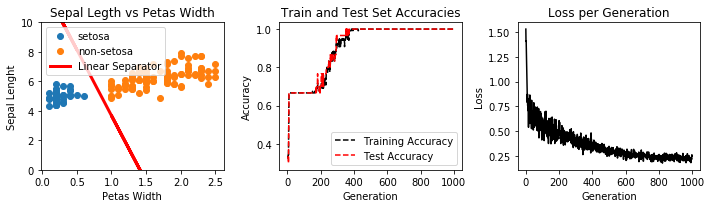

In [42]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(setosa_x,setosa_y,'o',label='setosa')
ax[0].plot(not_setosa_x,not_setosa_y,'o',label='non-setosa')
ax[0].plot(x1_vals,best_fit,'r-',label='Linear Separator',linewidth=3)
ax[0].set_ylim([0,10])
ax[0].legend(loc='best')
ax[0].set_title('Sepal Legth vs Petas Width')
ax[0].set_xlabel('Petas Width')
ax[0].set_ylabel('Sepal Lenght')

ax[1].plot(train_acc,'k--',label='Training Accuracy')
ax[1].plot(test_acc,'r--',label='Test Accuracy')
ax[1].set_title("Train and Test Set Accuracies")
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')

ax[2].plot(loss_vec,'k-')
ax[2].set_title('Loss per Generation')
ax[2].set_xlabel('Generation')
ax[2].set_ylabel('Loss')

plt.tight_layout()

# Reduction to linear regression
같은 maximun margin 개념이 선형회귀에도 적용될 수 있다.<br>
두 클래스를 구분하는 마진을 최대화하는 것 대신 (x,y) 데이터들을 포함하는 마진을 최대화하는 것을 생각 할 수 있다.

loss 함수를 $max(0,|y_{i}-(Ax_{i}+b)|-\epsilon)$로 정의한다. $\epsilon$은 마진의 width를 나타내는데 이 폭 내에 있는 데이터들의 loss를 0으로 만든다.

In [52]:
# 1.
x_vals = iris_df.iloc[:,3].values
y_vals = iris_df.iloc[:,0].values

train_indices = np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False)
test_indices = np.array(list(set(range(len(x_vals)))-set(train_indices)))
x_vals_train = x_vals[train_indices].reshape(-1,1)
x_vals_test = x_vals[test_indices].reshape(-1,1)
y_vals_train = y_vals[train_indices].reshape(-1,1)
y_vals_test = y_vals[test_indices].reshape(-1,1)

# overfitting을 막기 위해서 validation set까지 분리할 수 있다.

# 2.
batch_size = 50
x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)

A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

model_output = tf.add(tf.matmul(x_data,A),b)

In [53]:
# 3. epsilon을 0.5로 설정, epsilon은 loss 함수에서 hard 마진 대신에 soft 마진을 허용하는 부분이다.

epsilon = tf.constant([0.5])
loss = tf.reduce_mean(tf.maximum(0.,tf.subtract(tf.abs(tf.subtract(model_output,y_target)),epsilon)))

In [54]:
# 4.
my_opt = tf.train.GradientDescentOptimizer(0.075)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()

In [57]:
# 5.
sess.run(init)

train_loss = []
test_loss = []
for i in range(200):
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = x_vals_train[rand_index].reshape(-1,1)
    rand_y = y_vals_train[rand_index].reshape(-1,1)
    
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
    
    temp_train_loss = sess.run(loss,feed_dict={x_data:x_vals_train,y_target:y_vals_train})
    train_loss.append(temp_train_loss)
    
    temp_test_loss = sess.run(loss,feed_dict={x_data:x_vals_test,y_target:y_vals_test})
    test_loss.append(temp_test_loss)
    
    if (i+1)%50 == 0:
        print('\n')
        print('Generation : {} A = {}, b = {}'.format(i+1,sess.run(A),sess.run(b)))
        print('Train Loss = {}, Test Loss = {}'.format(temp_train_loss,temp_test_loss))



Generation : 50 A = [[2.270943]], b = [[2.493564]]
Train Loss = 0.6736113429069519, Test Loss = 0.5561034083366394


Generation : 100 A = [[1.747592]], b = [[3.4835644]]
Train Loss = 0.32516276836395264, Test Loss = 0.2402448058128357


Generation : 150 A = [[1.3274424]], b = [[4.1930647]]
Train Loss = 0.13878841698169708, Test Loss = 0.06483818590641022


Generation : 200 A = [[1.0971924]], b = [[4.499065]]
Train Loss = 0.09841251373291016, Test Loss = 0.04691614955663681


In [58]:
# 7.
[[slope]] = sess.run(A)
[[y_intercept]] = sess.run(b)
[width] = sess.run(epsilon)

best_fit = []
best_fit_upper = []
best_fit_lower = []
for i in x_vals:
    best_fit.append(slope*i+y_intercept)
    best_fit_upper.append(slope*i+y_intercept+width)
    best_fit_lower.append(slope*i+y_intercept-width)


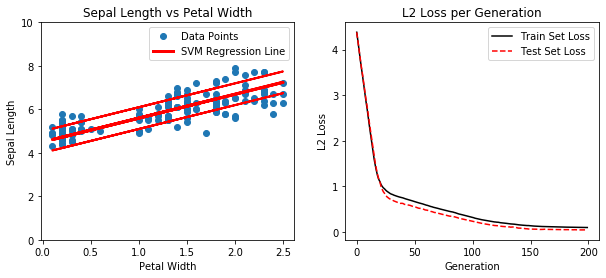

In [61]:
# 8. 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x_vals,y_vals,'o',label='Data Points')
ax[0].plot(x_vals,best_fit,'r-',label='SVM Regression Line',linewidth=3)

ax[0].plot(x_vals,best_fit_upper,'r-',linewidth=2)

ax[0].plot(x_vals,best_fit_lower,'r-',linewidth=2)

ax[0].set_ylim([0,10])
ax[0].legend(loc='best')
ax[0].set_title('Sepal Length vs Petal Width')
ax[0].set_xlabel('Petal Width')
ax[0].set_ylabel('Sepal Length')

ax[1].plot(train_loss,'k-',label='Train Set Loss')
ax[1].plot(test_loss,'r--',label='Test Set Loss')
ax[1].set_title('L2 Loss per Generation')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('L2 Loss')
ax[1].legend(loc='best')

그래프를 보면 SVM regression이 가능한한 많은 포인트들을 라인으로부터 2$\epsilon$ 마진 width에 맞췄다는 것을 확인할 수 있다.<br>
이러한 fitting이 파라미터에 대해 다소 감각적인데 너무 작은 $\epsilon$을 택하면 알고리즘은 많은 포인트를 마진에 맞추지 못할 것이고 너무 큰 $\epsilon$을 택하면 모든 데이터를 마진 안에 넣어버리는 일이 생길 것이다.<br>
보통은 작은 $\epsilon$을 선호하는데 마진에 가까운 포인트들이 먼 포인트보다 loss 함수를 작게 만드는데 더 공헌하기 때문이다.

# Woking with kernels in TensorFlow
이전의 SVM 알고리즘들은 선형 경계를 가진 데이터에서 동작했다. 그런데 만약 비선형 경계를 가진 데이터를 분류한다면 선형 경계를 어떻게 데이터로 투영할지 고민해야한다. 이는 SVM loss 함수에서의 kernel을 변경함으로서 해결할 수 있다.

이번 절을 통해 어떻게 커널을 수정하고 어떻게 비선형 경계 데이터를 분류하는지 살펴보도록 한다.

선형 SVM section에서 soft margin의 경우를 보았는데, 이에 대한 다른 접근으로는 dual of the optimization problem이라는 것을 푸는 것이다. 선형 SVM 문제의 dual은 다음과 같은 식으로 정의된다.<br>
$max \sum_{i=1}^n b_i - {1\over2}\sum_{i=1}^n \sum_{j=1}^n b_ib_jy_iy_j(x_i{\cdot}x_j)$<br>
subject to $\sum_{i=1}^nb_iy_i = 0$ & $0<=b_i<={1\over{2n\gamma}}$

여기서 모델의 변수는 b벡터이다. 이상적으로 이 벡터는 완전히 sparse하고 오직 -1과 1에 가까운 값들만을 취할 것이다. 데이터포인트 벡터는 $x_i$, 1과 -1로 이뤄진 타겟은 $y_i$로 나타내진다.

이 방정식의 커널은 dot product ,$x_i{\cdot}x_j$이다. 이 커널은 linear kernel이다. 이 선형 커널은 데이터포인트들의 i,j 곱으로 이뤄진 정방행렬이다.

데이터포인트들을 dot product하는 것 대신, 복잡한 함수를 이용해 선형적으로 분리되는 더 큰 차원으로 확장할 수 있다.<br>
$k(x_i,x_j) = \phi(x_i){\cdot}\phi(x_j)$<br>
이 k는 커널 function이다.일반적인 커널은 Gaussian kernel(radial basis function kernel, RBF kernel)이 사용된다.<br>
$k(x_i,x_j) = e^{-\gamma}||x_i-x_j||^2$<br>
이 커널에서 예측을 만들기 위해 $p_i$라고 하는 포인트로 예측값을 대체하도록 한다.<br>
$k(x_i,p_j) = e^{-\gamma}||x_i-p_j||^2$

이번 절을 통해 가우시안 커널을 어떻게 시행할 수 있을지 살펴보도록 한다. 또한 언제 선형 커널을 대체해야하는지 역시 살피도록 한다. <br>여기서 사용하게 될 데이터셋은 선형 커널보다는 가우시안 커널에 적합한 분포를 갖는다.

In [9]:
# 1, 2.
from sklearn.datasets import make_circles
(x_vals,y_vals) = make_circles(n_samples=350,factor=.5,noise=.1)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]
sess = tf.Session()

# 3. 배치 사이즈, placeholder, 모델 variable, b를 정의
# 매 훈련 generation마다 변동이 심하지 않은 안정된 모델을 만들기 위해 SVM은 큰 배치사이즈를 선호한다.
# 또한 예측 포인트에 대한 또 다른 placeholder를 만들어둔다.
# 어느 영역이 어떤 클래스에 속하는지 시각화를 위해 컬러 그리드를 만들어낸다.

batch_size=350
x_data = tf.placeholder(shape=[None,2],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None,2],dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

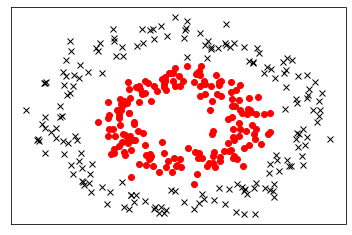

In [24]:
plt.plot(class1_x,class1_y,'ro',label='Class 1')
plt.plot(class2_x,class2_y,'kx',label='Class -1')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [25]:
# 4. 가우시안 커널 정의
gamma = tf.constant(-50.0)
dist = tf.reshape(tf.reduce_sum(tf.square(x_data),1),[-1,1])
sq_dists = tf.add(tf.subtract(dist,tf.multiply(2.,tf.matmul(x_data,tf.transpose(x_data)))),tf.transpose(dist))

my_kernel = tf.exp(tf.multiply(gamma,tf.abs(sq_dists)))

In [26]:
# 5. dual problem을 선언
# 마지막에는, 최대화하는 대신 tf.negative()를 사용해 negative loss 함수를 최소화할 것이다.

model_output = tf.matmul(b,my_kernel)
first_term = tf.reduce_sum(b)

b_vec_cross = tf.matmul(tf.transpose(b),b)
y_target_cross = tf.matmul(y_target,tf.transpose(y_target))

second_term = tf.reduce_sum(tf.multiply(my_kernel,tf.multiply(b_vec_cross,y_target_cross)))

loss = tf.negative(tf.subtract(first_term,second_term))

In [27]:
# 6. 예측과 정확도에 관한 함수를 정의
# 먼저 step 4처럼 prediction kernel을 정의(포인트 그 자체의 커널보다)
# 예측은 모델 아웃풋의 부호이다.

rA = tf.reshape(tf.reduce_sum(tf.square(x_data),1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid),1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA,tf.multiply(2.,tf.matmul(x_data,tf.transpose(prediction_grid)))),tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma,tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b),pred_kernel)
prediction = tf.sign(tf.subtract(prediction_output,tf.reduce_mean(prediction_output)))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)),tf.float32))

# linear kernel : pred_kernel = tf.matmul(x_data,tf.transpose(predicion_grid))

In [28]:
# 7. 
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()

In [29]:
# 8. loss vector와 batch accuracy를 매 generation마다 기록한다.
# 정확도를 측정할 때는 세 개의 placeholder를 집어넣는다.
sess.run(init)
loss_vec = []
batch_acc = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,2)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step,feed_dict={x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy,feed_dict={x_data:rand_x,y_target:rand_y,prediction_grid:rand_x})
    batch_acc.append(acc_temp)
    if (i+1)%250 == 0:
        print('Step # {} ,Loss = {}, accuracy = {}'.format(i+1,temp_loss,acc_temp))

Step # 250 ,Loss = 44.374000549316406, accuracy = 0.7599999904632568
Step # 500 ,Loss = -5.889392852783203, accuracy = 0.9571428298950195
Step # 750 ,Loss = -10.388936996459961, accuracy = 0.991428554058075
Step # 1000 ,Loss = -10.69218635559082, accuracy = 0.9885714054107666


In [15]:
# 10.
x_min,x_max = x_vals[:,0].min()-1,x_vals[:,0].max()+1
y_min,y_max = x_vals[:,1].min()-1,x_vals[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.02),
                    np.arange(y_min,y_max,0.02))

grid_points = np.c_[xx.ravel(),yy.ravel()]

In [16]:
[grid_predictions] = sess.run(prediction,
                              feed_dict={x_data:x_vals,y_target:y_vals.reshape(-1,1),prediction_grid:grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Text(0, 0.5, 'Loss')

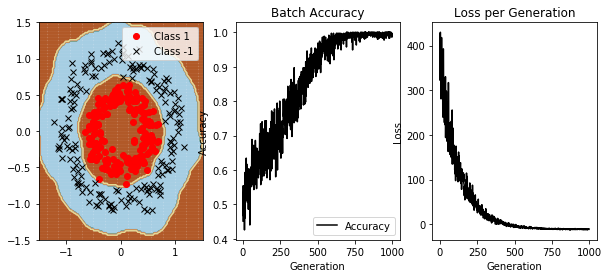

In [17]:
fig,ax = plt.subplots(1,3,figsize=(10,4))

ax[0].contour(xx,yy,grid_predictions,cmap=plt.cm.Paired,alpha=0.8)
ax[0].pcolor(xx,yy,grid_predictions,cmap=plt.cm.Paired,alpha=0.8)

ax[0].plot(class1_x,class1_y,'ro',label='Class 1')
ax[0].plot(class2_x,class2_y,'kx',label='Class -1')
ax[0].legend(loc='best')
ax[0].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,1.5])

ax[1].plot(batch_acc,'k-',label='Accuracy')
ax[1].set_title('Batch Accuracy')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')

ax[2].plot(loss_vec,'k-')
ax[2].set_title('Loss per Generation')
ax[2].set_xlabel('Generation')
ax[2].set_ylabel('Loss')

# Implementing a non-linear SVM
Gaussian kernel SVM을 iris 데이터에 사용해보도록 한다.

In [30]:
# 1. 2.
from sklearn.datasets import load_iris
iris = load_iris()
x_vals = iris.data[:,[0,3]]
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

In [31]:
# 3.
batch_size = 150
x_data = tf.placeholder(shape=[None,2],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None,2],dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

In [32]:
# 4. Gaussian kernel을 선언, gamma 변수에 의존
gamma = tf.placeholder(dtype=tf.float32)
sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

In [33]:
first_term = tf.reduce_sum(b)

b_vec_cross = tf.matmul(tf.transpose(b),b)
y_target_cross = tf.matmul(y_target,tf.transpose(y_target))

second_term = tf.reduce_sum(tf.multiply(my_kernel,tf.multiply(b_vec_cross,y_target_cross)))

loss = tf.negative(tf.subtract(first_term,second_term))

In [34]:
# 5. prediction kernel과 accuracy kernel을 정의

rA = tf.reshape(tf.reduce_sum(tf.square(x_data),1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid),1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA,tf.multiply(2.,tf.matmul(x_data,tf.transpose(prediction_grid)))),tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma,tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b),pred_kernel)
prediction = tf.sign(tf.subtract(prediction_output,tf.reduce_mean(prediction_output)))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)),tf.float32))



In [35]:
# 6.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

In [36]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

In [37]:
from tqdm import tqdm_notebook

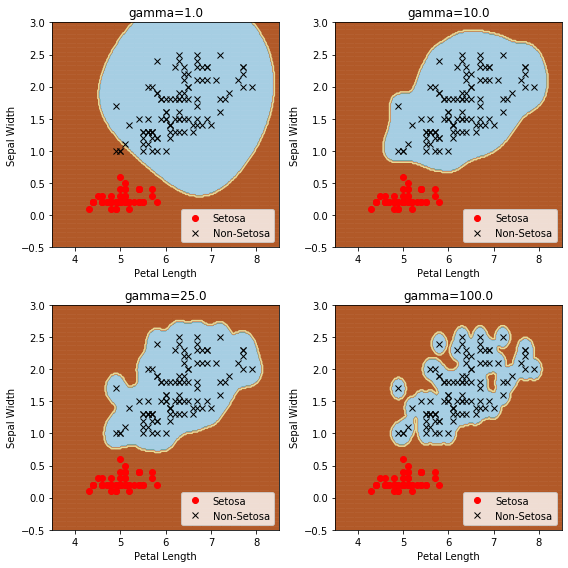

In [39]:
# 7.
init = tf.global_variables_initializer()
sess.run(init)
fig,ax = plt.subplots(2,2,figsize=(8,8))
gamma_list = [-1.0,-10.0,-25.0,-100.0]


for n,axes in tqdm_notebook(enumerate(ax.flatten())):
    loss_vec = []
    batch_accuracy = []
    for i in tqdm_notebook(range(300)):
        gamma_ = gamma_list[n]
        rand_index = np.random.choice(len(x_vals),size=batch_size)
        rand_x = x_vals[rand_index].reshape(-1,2)
        rand_y = y_vals[rand_index].reshape(-1,1)
        sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y,gamma:gamma_})

        temp_loss = sess.run(loss,feed_dict = {x_data:rand_x,y_target:rand_y,gamma:gamma_})
        loss_vec.append(temp_loss)

        acc_temp = sess.run(accuracy,feed_dict = {x_data:rand_x,y_target:rand_y,prediction_grid:rand_x,gamma:gamma_})
        batch_accuracy.append(acc_temp)

        [grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                         y_target: np.transpose([y_vals]),
                                                         prediction_grid: grid_points,gamma:gamma_})
        grid_predictions = grid_predictions.reshape(xx.shape)

    axes.contour(xx,yy,grid_predictions,cmap=plt.cm.Paired,alpha=0.8)
    axes.pcolor(xx,yy,grid_predictions,cmap=plt.cm.Paired,alpha=0.8)
    axes.plot(class1_x,class1_y,'ro',label='Setosa')
    axes.plot(class2_x,class2_y,'kx',label='Non-Setosa')
    axes.set_title('gamma={}'.format(-1*gamma_))
    axes.set_xlabel('Petal Length')
    axes.set_ylabel('Sepal Width')
    axes.legend(loc='lower right')
    axes.set_ylim([-0.5,3.0])
    axes.set_xlim([3.5,8.5])
plt.tight_layout()

# Implementing a multi-class SVM
두 개의 클래스를 분류하는 것을 넘어 여러 개 클래스 분류에 대해 다뤄볼 것이다.

원래 SVM은 이진 분류를 위해 고안되었으나 다중 분류를 위한 시도들이 있었고 두 개의 주요한 전략은 One versus all과 One versus one이다.

One versus all은 모든 가능한 클래스 쌍에 대해서 이진 분류를 시행하는 것이다. 그리고 투표의 방식으로 예측이 만들어진다. 그러나 이 방식은 계산량이 매우 많다. k개의 클래스를 구분하기 위해 ${k! \over (k-2)!}*2!$개의 분류기를 만들어야한다.

또 다른 방식은 하나에 대해 k개의 클래스에 대해 각각 분류기를 만들어내는 것이다. 예측 클래스는 가장 큰 SVM margin을 만들어내는 클래스이다. 이번 절에서는 이 전략을 사용한다.

iris데이터를 사용하고 각 클래스를 위한 세 개의 Gaussian kernel을 만든 후 가장 높은 마진이 있는 예측 포인트를 만들어낼 것이다.

In [13]:
sess = tf.Session()

In [3]:
# 1.
from sklearn.datasets import load_iris

# 2.
iris = load_iris()
x_vals = iris.data[:,[0,3]]
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1,y_vals2,y_vals3])

class1_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==2]

In [7]:
# 3. 이전 비선형 SVM 분류에 비해 달라진 가장 큰 점은 많은 차원이 달라진다는 것이다.
# 세 번의 SVM을 한 번에 시행하기 위해 matrix broadcasting과 reshape을 사용할 것이다.
# 이것을 시행하기 위해 y_target placeholder의 차원을 [3,None]으로, b를 [3,batch_size]로 설정할 것이다.

batch_size = 50
x_data = tf.placeholder(shape=[None,2],dtype=tf.float32)
y_target = tf.placeholder(shape=[3,None],dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None,2],dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

In [8]:
# 4. Gaussian kernel 정의, input x-data로부터 결정되므로 이전 recipe에서 변하지 않는다.
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data),1)
dist = tf.reshape(dist,[-1,1])
sq_dist = tf.add(tf.subtract(dist,tf.multiply(2.,tf.matmul(x_data,tf.transpose(x_data)))),tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma,tf.abs(sq_dist)))

In [9]:
# 5. 한가지 중요한 변화는 batch_matrix multiplicatain을 수행한다는 것이다.
# 결국 3차원 행렬을 다루게 되고 3번째 index에 대해 행렬곱들을 
# 브로드캐스팅하고자 하는데 데이터가 이를 위해 세팅되어있지는 않다.
# x^T*x와 같은 연산을 나머지 차원에서 수행하기 위해 함수를 정의해 사용할 것이다.

def reshape_matmul(mat, _size):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, _size, 1])
    return tf.matmul(v2, v1)


In [10]:
# 6. 만들어진 함수를 바탕으로 dual loss 함수를 계산한다.
model_output = tf.matmul(b,my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b),b)
y_target_cross = reshape_matmul(y_target,batch_size)

second_term = tf.reduce_sum(tf.multiply(my_kernel,tf.multiply(b_vec_cross,y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term,second_term)))

In [11]:
# 7. 8. prediction kernel, accuracy_kernel 정의
# reduce_sum 함수를 주의해서 사용해야한다.

rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., 
                                                  tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(y_target, b), pred_kernel)
prediction = tf.argmax(prediction_output - tf.expand_dims(tf.reduce_mean(prediction_output, 1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target, 0)), tf.float32))

In [12]:
# 9.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

In [14]:
# 10.
init = tf.global_variables_initializer()
sess.run(init)

loss_vec = []
batch_accuracy = []
for i in range(100):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,2)
    rand_y = y_vals[:,rand_index].reshape(3,-1)
    sess.run(train_step, feed_dict = {x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss,feed_dict = {x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy,feed_dict={x_data:rand_x,y_target:rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%25 == 0:
        print('Step # {}, loss = {}'.format(i+1,temp_loss))

Step # 25, loss = -5.850759506225586
Step # 50, loss = -26.94124984741211
Step # 75, loss = -27.941469192504883
Step # 100, loss = -32.32640838623047


In [15]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data: rand_x,
                                                   y_target: rand_y,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Text(0, 0.5, 'Loss')

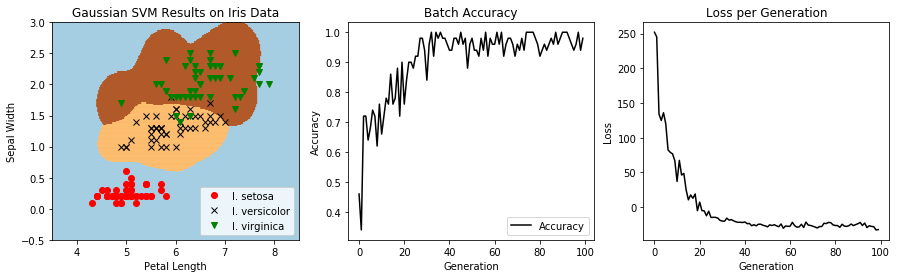

In [18]:
fig,ax = plt.subplots(1,3,figsize=(15,4))

ax[0].contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
ax[0].pcolor(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
ax[0].plot(class1_x, class1_y, 'ro', label='I. setosa')
ax[0].plot(class2_x, class2_y, 'kx', label='I. versicolor')
ax[0].plot(class3_x, class3_y, 'gv', label='I. virginica')
ax[0].set_title('Gaussian SVM Results on Iris Data')
ax[0].set_xlabel('Petal Length')
ax[0].set_ylabel('Sepal Width')
ax[0].legend(loc='lower right')
ax[0].set_ylim([-0.5, 3.0])
ax[0].set_xlim([3.5, 8.5])

ax[1].plot(batch_accuracy, 'k-', label='Accuracy')
ax[1].set_title('Batch Accuracy')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='lower right')

ax[2].plot(loss_vec, 'k-')
ax[2].set_title('Loss per Generation')
ax[2].set_xlabel('Generation')
ax[2].set_ylabel('Loss')